In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import glob
from glob import iglob
from pathlib import Path
import cv2
import random

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl

import sklearn
import matplotlib as plt

In [2]:
#some constants
img_size=100
batch_size=128

In [16]:
#resize and store
path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages/Dog'
dest_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Dog/'

files = [f for f in glob.glob(path + "**/*.jpg", recursive=True)]

for f in files:
    basename = os.path.basename(f)
    file_name = os.path.splitext(basename)[0]
    try:
        im = cv2.imread(f)
        im = cv2.resize(im,(img_size,img_size))
        cv2.imwrite(os.path.join(dest_path , file_name + '.jpg'), im)
    except: 
        print('bad file')


bad file
bad file


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


bad file
bad file
bad file
bad file
bad file
bad file


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


bad file
bad file
bad file
bad file
bad file
bad file
bad file


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


bad file


bad file
bad file
bad file
bad file
bad file


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


bad file
bad file


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


bad file


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


bad file


In [24]:
#create test set directory

path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat'
dest_path = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/'

files = [f for f in glob.glob(path + "**/*.jpg", recursive=True)]

for f in files:
    r = random.randrange(1,100)
    if(r<=10):
        basename = os.path.basename(f)
        file_name = os.path.splitext(basename)[0]
        file_destination = os.path.join(dest_path , file_name + '.jpg')
        print('moving ' + f + ' to ' + file_destination)
        shutil.move(f, file_destination)


moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/1409.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/1409.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/11995.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/11995.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/3222.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/3222.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/5647.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/5647.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_

moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/12.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/12.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/4500.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/4500.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/1478.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/1478.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/12235.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/12235.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_data

moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/4633.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/4633.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/4960.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/4960.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/8828.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/8828.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/1824.jpg to /Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/Cat/1824.jpg
moving /Users/rogierlandman/from_Samsung/Machine_learning_da

In [13]:
print(os.path.join(dest_path , file_name + '.jpg'))

/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1/Cat/11565.jpg


In [68]:
#make training dataset
data_dir = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', 
    label_mode='int',
    color_mode='rgb',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)


#make validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', 
    label_mode='int',
    color_mode='rgb',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)

test_set_directory = '/Users/rogierlandman/from_Samsung/Machine_learning_datasets/kagglecatsanddogs_3367a/PetImages1_test_set/'


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_set_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    validation_split=None,
    subset=None,
    seed=42,
    image_size=(img_size, img_size),
    crop_to_aspect_ratio=False,
    batch_size=batch_size)




Found 22307 files belonging to 2 classes.
Using 17846 files for training.
Found 22307 files belonging to 2 classes.
Using 4461 files for validation.
Found 2606 files belonging to 2 classes.


In [69]:
chosen_model = 'MobileNetV2'
chosen_model = 'Xception'

if(chosen_model == 'Xception'):
    #Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(img_size, img_size, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.
    
    
    
if(chosen_model == 'MobileNetV2'):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=True,
        weights="imagenet",
    )    
    

In [70]:
base_learning_rate = 0.001

if(chosen_model == 'Xception'):
    
     # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = inputs  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    #x=keras.layers.Dense(1024,activation='relu')(x)
    #x=keras.layers.Dense(512,activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.summary()

    
    model.compile(
        optimizer=keras.optimizers.Adam(base_learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )
    
if(chosen_model == 'MobileNetV2'):
    
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.Dropout(.2)(x)
    prediction_layer = tf.keras.layers.Dense(1)
    # YOUR CODE ENDS HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['binary_accuracy'])
    

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                           

Epoch 1/3
140/140 [==============================] - 276s 2s/step - loss: 0.2714 - binary_accuracy: 0.8775 - val_loss: 0.2048 - val_binary_accuracy: 0.9157
Epoch 2/3
140/140 [==============================] - 275s 2s/step - loss: 0.2083 - binary_accuracy: 0.9125 - val_loss: 0.1887 - val_binary_accuracy: 0.9215
Epoch 3/3
140/140 [==============================] - 281s 2s/step - loss: 0.1984 - binary_accuracy: 0.9168 - val_loss: 0.1881 - val_binary_accuracy: 0.9222


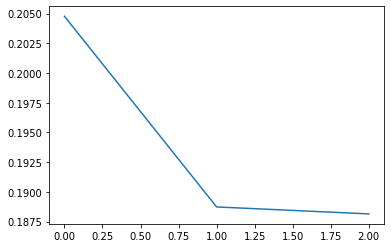

In [71]:
epochs = 3

if(chosen_model == 'Xception'):
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
if(chosen_model == 'MobileNetV2'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

plt.plot(history.history['val_loss'])

In [84]:
import sklearn.metrics as metrics

predictions = model.predict(test_ds)
predictions = predictions.ravel()
predictions = np.int32(np.round(predictions))

test_label = np.concatenate([y for x, y in test_ds], axis=0)

confusion_matrix = metrics.confusion_matrix(test_label, predictions)
print(confusion_matrix)

F1 = metrics.f1_score(test_label, predictions)
print('F1 score: ', F1)

precision = metrics.precision_score(test_label, predictions)
print('precision: ', precision)

recall = metrics.recall_score(test_label, predictions)
print('recall: ', recall)


[[1107  134]
 [ 106 1259]]
F1 score:  0.9129804205946339
precision:  0.9038047379755922
recall:  0.9223443223443224
